<a href="https://colab.research.google.com/github/yankchina/ColabNotebook/blob/main/Github_Trending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Github Trending Note

Github Trending 研究笔记


## 2021-01-19


### Yfinance

https://github.com/ranaroussi/yfinance

Download market data from Yahoo! Finance's API

这样可以下载 Yahoo 财经数据

> 通过我的测试，这个库能够下载的资料还是很多的

In [6]:
#!pip install yfinance --upgrade --no-cache-dir

import yfinance as yf

msft = yf.Ticker("MSFT")

print(msft.info)

hist = msft.history(period = "max")
print(hist)

actions = msft.actions
print(actions)

news = msft.news
for index, item in enumerate(news):
  print(index,item)

{'zip': '98052-6399', 'sector': 'Technology', 'fullTimeEmployees': 181000, 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, OneDrive, and LinkedIn; and Dynamics 365, a set of cloud-based and on-premises business solutions for organizations and enterprise divisions. Its Intelligent Cloud segment licenses SQL, Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also offers support services and Microsoft consulting services to assist customers in developing, deploying, and managing Microsoft server and desktop solutions; and training and certificatio

### facebookresearch/mae

https://github.com/facebookresearch/mae

[Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/abs/2111.06377) 论文的源代码

这个工具就是用来处理一些局部数据缺失的图片，通过人工智能的模式将图片增补复原。

经过我的测试，这个人工智能 AI 所能够复原图片的效果还是非常惊人的

In [7]:
# 其官方提供的 Colab Notebook 链接在这里 https://colab.research.google.com/github/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb

import sys
import os
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
     |████████████████████████████████| 287 kB 5.1 MB/s 
Cloning into 'mae'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 35 (delta 11), reused 33 (delta 9), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [43]:
# define the utils
# 定义一些工具函数

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
mask_ratio = 0.2

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=mask_ratio )
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

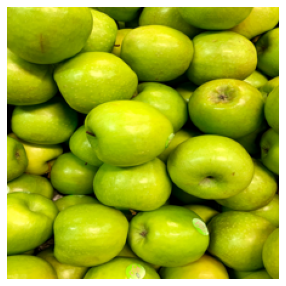

In [40]:
# load an image
# 装载官方用的图片
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img_url = 'https://source.unsplash.com/random/600×600/?fruit' # get random photo from unsplash.com
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [12]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.
--2022-01-19 07:33:40--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318315181 (1.2G) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_large_ganloss.pth’

mae_visualize_vit_l 100%[===================>]   1.23G  28.9MB/s    in 45s     

2022-01-19 07:34:25 (28.2 MB/s) - ‘mae_visualize_vit_large_ganloss.pth’ saved [1318315181/1318315181]

<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:


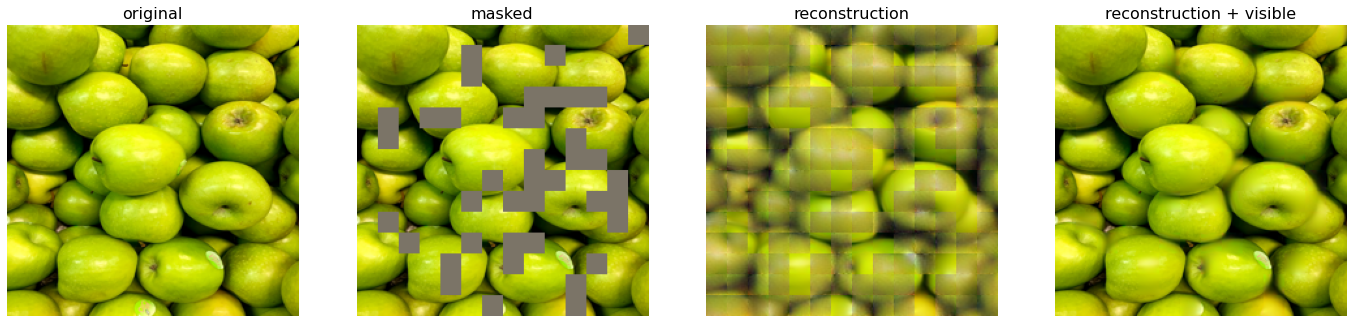

In [44]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

MAE with extra GAN loss:


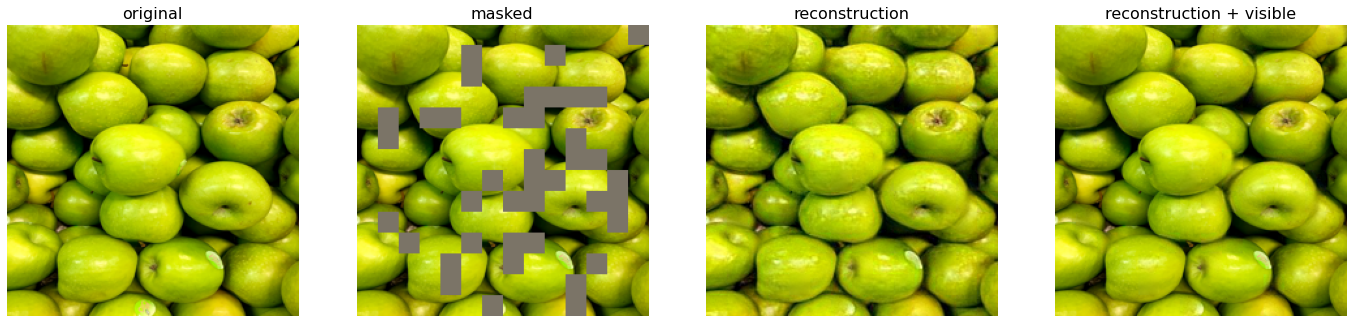

In [45]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

### openvinotoolkit/open_model_zoo

这个是给出一些可以免费商用的 深度学习模型（下载地址与样例文件），这样我们就可以很快地通过这些案例来构建自己的 AI 应用程序。

https://github.com/openvinotoolkit/open_model_zoo

### microsoft/Swin-Transformer

https://github.com/microsoft/Swin-Transformer

这是 微软公司 团队研发的一个变换器，这个变换器可用于多个图像分析领域

- Image Classification: 图片分类器
- Object Detection and Instance Segmentation: 对象识别与实例分解
- Semantic Segmentation:
- Video Action Recognition
- Semi-Supervised Object Detection
- SSL: Constrastive Learning
- SSL: Masked Image Modeling


> 这个库还是比较大，暂时还只能放在初步学习的位置上

### Pillow

这是一个非常基础的图像库，对于图像所能做的事情，这个库都可以完成

https://github.com/python-pillow/Pillow

可以将这个库作为基础组件，封装在 Python Docker 中